In [1]:
!pip -q install imbalanced-learn seaborn


In [2]:
import pandas as pd

df = pd.read_csv('Creditcard_data.csv')
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,1
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df['Class'].value_counts()



,count
Class,
0,763
1,9


In [4]:
from sklearn.model_selection import train_test_split

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (617, 30)
Test shape: (155, 30)


In [5]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN

sampling_methods = {
    "Sampling1_RandomUnder": RandomUnderSampler(random_state=42),
    "Sampling2_RandomOver": RandomOverSampler(random_state=42),
    "Sampling3_SMOTE": SMOTE(random_state=42),
    "Sampling4_ADASYN": ADASYN(random_state=42),
    "Sampling5_SMOTEENN": SMOTEENN(random_state=42)
}


In [6]:
sampled_data = {}

for name, sampler in sampling_methods.items():
    X_res, y_res = sampler.fit_resample(X_train, y_train)
    sampled_data[name] = (X_res, y_res)
    print(name, "->", y_res.value_counts().to_dict())


Sampling1_RandomUnder -> {0: 7, 1: 7}
Sampling2_RandomOver -> {0: 610, 1: 610}
Sampling3_SMOTE -> {0: 610, 1: 610}
Sampling4_ADASYN -> {0: 610, 1: 609}
Sampling5_SMOTEENN -> {1: 474, 0: 379}


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = {
    "M1_Logistic": LogisticRegression(max_iter=3000),
    "M2_KNN": KNeighborsClassifier(),
    "M3_DecisionTree": DecisionTreeClassifier(),
    "M4_RandomForest": RandomForestClassifier(),
    "M5_SVM": SVC()
}


In [8]:
from sklearn.metrics import accuracy_score
import pandas as pd

results = pd.DataFrame(index=models.keys(), columns=sampling_methods.keys())

for model_name, model in models.items():
    for sample_name, (X_res, y_res) in sampled_data.items():

        model.fit(X_res, y_res)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred) * 100
        results.loc[model_name, sample_name] = round(acc,2)

results


,Sampling1_RandomUnder,Sampling2_RandomOver,Sampling3_SMOTE,Sampling4_ADASYN,Sampling5_SMOTEENN
M1_Logistic,52.26,90.97,91.61,92.9,88.39
M2_KNN,49.03,96.77,67.1,68.39,61.94
M3_DecisionTree,37.42,98.71,97.42,95.48,93.55
M4_RandomForest,56.13,99.35,99.35,99.35,98.71
M5_SVM,69.68,70.97,28.39,32.9,27.1


In [9]:
results.to_csv("accuracy_table.csv")
results


,Sampling1_RandomUnder,Sampling2_RandomOver,Sampling3_SMOTE,Sampling4_ADASYN,Sampling5_SMOTEENN
M1_Logistic,52.26,90.97,91.61,92.9,88.39
M2_KNN,49.03,96.77,67.1,68.39,61.94
M3_DecisionTree,37.42,98.71,97.42,95.48,93.55
M4_RandomForest,56.13,99.35,99.35,99.35,98.71
M5_SVM,69.68,70.97,28.39,32.9,27.1


In [10]:
best = results.stack().astype(float).idxmax()
best_accuracy = results.stack().astype(float).max()

print("Best Combination:")
print("Model:", best[0])
print("Sampling:", best[1])
print("Accuracy:", best_accuracy)


Best Combination:
Model: M4_RandomForest
Sampling: Sampling2_RandomOver
Accuracy: 99.35


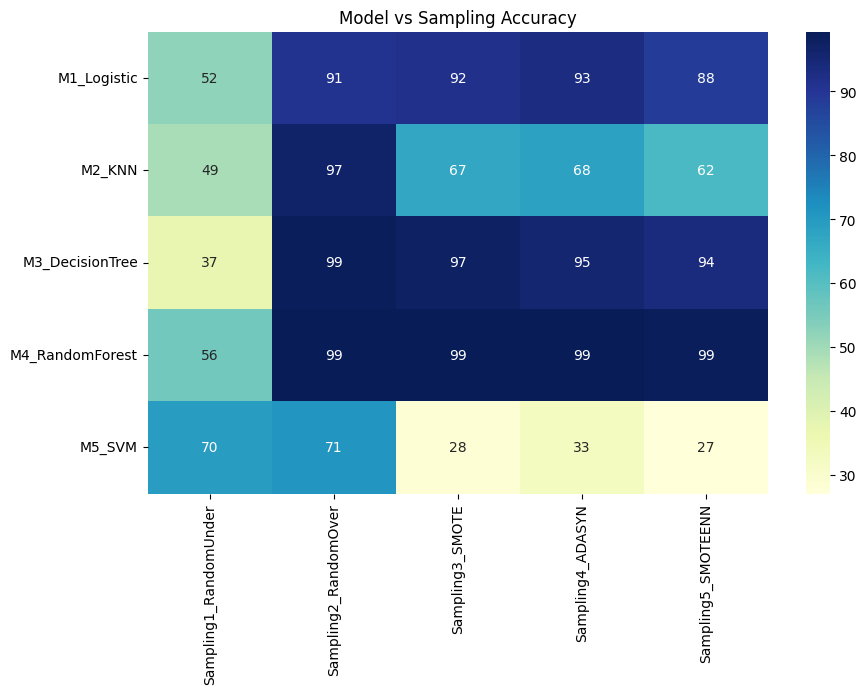

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(results.astype(float), annot=True, cmap="YlGnBu")
plt.title("Model vs Sampling Accuracy")
plt.show()
